In [1]:
import numpy as np
import pandas as pd
from random import seed
from random import random


from datetime import date
import time
import scipy, scipy.signal
import os, os.path
import shutil
import matplotlib
import matplotlib.pyplot as plt

from pylab import imshow

# vgg16 model used for transfer learning on the dogs and cats dataset
from matplotlib import pyplot
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
# from keras.optimizers import SGD

from keras.layers import Conv2D
from keras.layers import MaxPooling2D

# from keras.optimizers import gradient_descent_v2
# SGD = gradient_descent_v2.SGD(...)

from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

import sys
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/NASA/Python_codes/')
import NASA_core as nc
# import NASA_plot_core.py as rcp

In [2]:
idx="EVI"
data_dir = "/Users/hn/Documents/01_research_data/NASA/VI_TS/05_SG_TS/"

In [3]:
file_names = ["SG_Walla2015_EVI_JFD.csv"]

data=pd.DataFrame()

for file in file_names:
    curr_file=pd.read_csv(data_dir + file)
    curr_file['human_system_start_time'] = pd.to_datetime(curr_file['human_system_start_time'])
    
    # These data are for 3 years. The middle one is the correct one
    all_years = sorted(curr_file.human_system_start_time.dt.year.unique())
    print (all_years)
    if len(all_years)==3 or len(all_years)==2:
        proper_year = all_years[1]
    elif len(all_years)==1:
        proper_year = all_years[0]
        
    # curr_file = curr_file[curr_file.human_system_start_time.dt.year==proper_year]
    data=pd.concat([data, curr_file])

data.reset_index(drop=True, inplace=True)
data.head(2)

[2014, 2015, 2016]


,ID,human_system_start_time,EVI
0,135073_WSDA_SF_2015,2014-01-05,0.173941
1,135073_WSDA_SF_2015,2014-01-15,0.086129


In [4]:
type(data.human_system_start_time[0])

pandas._libs.tslibs.timestamps.Timestamp

In [5]:
short_field = data[data.ID=="135073_WSDA_SF_2015"].copy()# 36 data 
long_field = data[data.ID=="139657_WSDA_SF_2015"].copy() # 37 data 

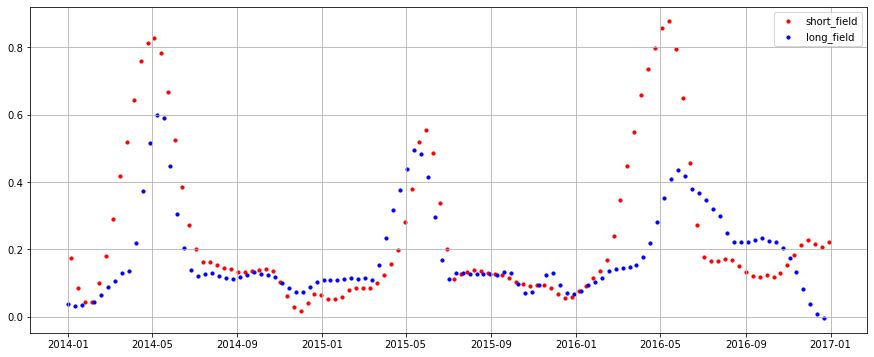

In [13]:
idx = "EVI"
fig, axs = plt.subplots(1, 1, figsize=(15, 6),
                        gridspec_kw={'hspace': 0.2, 'wspace': .1});

(ax1) = axs; ax1.grid(True);

ax1.scatter(short_field['human_system_start_time'], short_field[idx], 
            marker='o', s=10, c='r', label="short_field");

ax1.scatter(long_field['human_system_start_time'], long_field[idx], 
            marker='o', s=10, c='b', label="long_field");

ax1.legend(loc="upper right");
plt.show()

In [139]:
short_field.head(2)

,ID,human_system_start_time,EVI
0,135073_WSDA_SF_2015,2014-01-05,0.173941
1,135073_WSDA_SF_2015,2014-01-15,0.086129


In [140]:
long_field.head(2)

,ID,human_system_start_time,EVI
1650,139657_WSDA_SF_2015,2014-01-01,0.038058
1651,139657_WSDA_SF_2015,2014-01-11,0.032204


In [141]:
# Check Number of Data Points in a Year

In [142]:
# for an_ID in data.ID.unique():
#     crr_fld=data[data.ID==an_ID]
#     SFYr = crr_fld.human_system_start_time.dt.year.unique()[0]
#     print ("ID: ", an_ID,  " SFYr: ", SFYr, " shape[0]: ", crr_fld.shape[0])

In [143]:
interval_size = 10
pd.date_range(min(long_field.human_system_start_time), 
              max(long_field.human_system_start_time), 
              freq=str(interval_size)+'D')

DatetimeIndex(['2014-01-01', '2014-01-11', '2014-01-21', '2014-01-31',
               '2014-02-10', '2014-02-20', '2014-03-02', '2014-03-12',
               '2014-03-22', '2014-04-01',
               ...
               '2016-09-17', '2016-09-27', '2016-10-07', '2016-10-17',
               '2016-10-27', '2016-11-06', '2016-11-16', '2016-11-26',
               '2016-12-06', '2016-12-16'],
              dtype='datetime64[ns]', length=109, freq='10D')

In [148]:
# pd.Period("2012-05", freq="D")
# min(long_field.human_system_start_time)

# pd.date_range(pd.Timestamp(str(a_year) + "-01-01"), 
#                                     pd.Timestamp(str(a_year) + "-12-30"), 
#                                     freq=str(interval_size)+'D')

In [160]:
a_df

(110, 3)

In [182]:
a_df = long_field.copy()
V_idks = "EVI"

In [183]:
no_steps = len(all_years) * 36 # 36 data per year.
# no_steps = a_df_coverage_days // interval_size

# initialize output dataframe
if "dataset" in a_df.columns:
    regular_cols = ['ID', 'dataset', 'human_system_start_time', V_idks]
else:
    regular_cols = ['ID', 'human_system_start_time', V_idks]

regular_df = pd.DataFrame(data = None, 
                          index = np.arange(no_steps), 
                          columns = regular_cols)


regular_df['ID'] = a_df.ID.unique()[0]
if "dataset" in a_df.columns:
    regular_df['dataset'] = a_df.dataset.unique()[0]

In [184]:
regular_time_stamps = []
for a_year in all_years:
    curr_list = list(pd.date_range(pd.Timestamp(str(a_year) + "-01-01"), 
                                                pd.Timestamp(str(a_year) + "-12-25"), 
                                                freq=str(10)+'D'))
    regular_time_stamps = regular_time_stamps + curr_list
    print (len(curr_list))

36
36
36


In [185]:
no_steps_per_year = 365//interval_size
no_steps = len(all_years) * no_steps_per_year

In [186]:
# initialize output dataframe
if "dataset" in a_df.columns:
    regular_cols = ['ID', 'dataset', 'human_system_start_time', V_idks]
else:
    regular_cols = ['ID', 'human_system_start_time', V_idks]

regular_df = pd.DataFrame(data = None, 
                          index = np.arange(no_steps), 
                          columns = regular_cols)

In [187]:
regular_df['ID'] = a_df.ID.unique()[0]
if "dataset" in a_df.columns:
    regular_df['dataset'] = a_df.dataset.unique()[0]

In [188]:
if len(regular_time_stamps) == no_steps+1:
    regular_df.human_system_start_time = regular_time_stamps[:-1]
elif len(regular_time_stamps) == no_steps:
    regular_df.human_system_start_time = regular_time_stamps
else:
    raise ValueError(f"There is a mismatch between no. days needed and '{interval_size}-day' interval array!")

In [189]:
regular_df.head(2)

,ID,human_system_start_time,EVI
0,139657_WSDA_SF_2015,2014-01-01,NaN
1,139657_WSDA_SF_2015,2014-01-11,NaN


In [190]:
for start_date in regular_df.human_system_start_time:
    """
      The following will crate an array (of length 2)
      it goes from a day to 10 days later; end points of the interval_size-day interval.

            # Here we add 1 day to the right end point (end_date)
      because the way pandas/python slices the dataframe; 
      does not include the last row of sub-dataframe
    """
    dateRange = pd.date_range(start_date, 
                              start_date + pd.Timedelta(days=interval_size-1), 
                              freq = str(1)+'D')
    assert (len(dateRange) == interval_size)

    curr_time_window = a_df[a_df.human_system_start_time.isin(dateRange)]
    if len(curr_time_window)==0:
        regular_df.loc[regular_df.human_system_start_time == start_date, V_idks] = -1.5
    else:
        regular_df.loc[regular_df.human_system_start_time == start_date, V_idks] = max(curr_time_window[V_idks])

In [191]:
regular_df

,ID,human_system_start_time,EVI
0,139657_WSDA_SF_2015,2014-01-01,0.038058
1,139657_WSDA_SF_2015,2014-01-11,0.032204
2,139657_WSDA_SF_2015,2014-01-21,0.034155
3,139657_WSDA_SF_2015,2014-01-31,0.043912
4,139657_WSDA_SF_2015,2014-02-10,0.064129
...,...,...,...
103,139657_WSDA_SF_2015,2016-11-06,0.133308
104,139657_WSDA_SF_2015,2016-11-16,0.08226
105,139657_WSDA_SF_2015,2016-11-26,0.039073
106,139657_WSDA_SF_2015,2016-12-06,0.008226


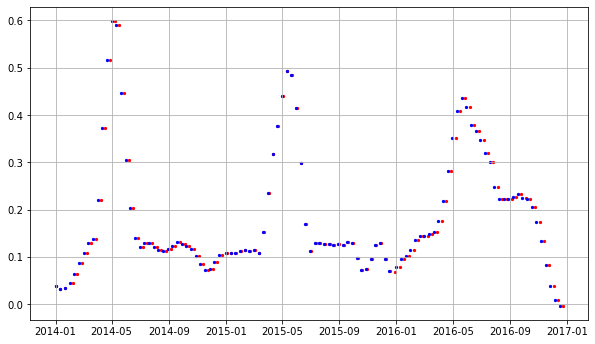

In [193]:
idx = "EVI"
fig, axs = plt.subplots(1, 1, figsize=(10, 6),
                        gridspec_kw={'hspace': 0.2, 'wspace': .1});

(ax1) = axs; ax1.grid(True);

ax1.scatter(a_df['human_system_start_time'], a_df[idx], 
            marker='o', s=5, c='r', label=idx);

ax1.scatter(regular_df['human_system_start_time'], regular_df[idx], 
            marker='o', s=5, c='b', label=idx);


plt.subplots_adjust(top=0.85)
plt.show()

In [194]:
regular_df.EVI.unique()

array([0.038058134487518, 0.032203939007667, 0.0341553375009507,
       0.0439123299673691, 0.0641290068257757, 0.0873818865082871,
       0.1075092019389673, 0.1290470107011193, 0.1369337831372984,
       0.2190829841016562, 0.3726631068248308, 0.5167041984834078,
       0.5988743634633394, 0.5902622734870324, 0.4462222908917541,
       0.3036420663635528, 0.203482851477502, 0.1402253965891996,
       0.1201718699873277, 0.1285360450397829, 0.1301299401050714,
       0.1216581623178149, 0.1144722868286251, 0.1131243284962655,
       0.1170742364051363, 0.123309144332316, 0.1317346707293848,
       0.1264182798619309, 0.1232383829792018, 0.1170485962493411,
       0.1011724467851688, 0.0844320044084155, 0.0729886911172525,
       0.0752733740514055, 0.0899858113419764, 0.1042133673966879,
       0.1080671708921015, 0.1081944782812967, 0.1089376118471389,
       0.1130019452197912, 0.1145516375322087, 0.1129370373362044,
       0.1139792525314926, 0.1083523705455076, 0.1528386788565236,

In [195]:
def regularize_a_field_annual_basis(a_df, V_idks="NDVI", interval_size=10, start_year=2008, end_year=2021):
    """Returns a dataframe where data points are interval_size-day apart.
       This function regularizes the data between the minimum and maximum dates
       present in the data. 

    Arguments
    ---------
    a_df : dataframe 
           of a given field for only one satellite

    Returns
    -------
    regularized_df : dataframe
    """
    if not("human_system_start_time" in a_df.columns):
        a_df = add_human_start_time_by_system_start_time(a_df)

    a_df['human_system_start_time'] = pd.to_datetime(a_df['human_system_start_time'])
    a_df.sort_values(by='human_system_start_time', inplace=True)
    a_df.reset_index(drop=True, inplace=True)
        

    assert (len(a_df.ID.unique()) == 1)
    # assert (len(a_df.dataset.unique()) == 1)
    #
    # see how many days there are between the first and last image
    #
    a_df_coverage_days = (max(a_df.human_system_start_time) - min(a_df.human_system_start_time)).days
    assert (a_df_coverage_days >= interval_size)

    # see how many data points we need.
    all_years = sorted(a_df.human_system_start_time.dt.year.unique())
    no_steps_per_year = 365//interval_size
    no_steps = len(all_years) * no_steps_per_year

    """
       I am reducing the flexibility of the code we had before!
       I want to make it that all fields have the same exact dates
       for their time steps. Jan. 1, Jan 10, ...
    """
    regular_time_stamps = []
    for a_year in all_years:
        regular_time_stamps = regular_time_stamps + list(pd.date_range(pd.Timestamp(str(a_year) + "-01-01"), 
                                                                       pd.Timestamp(str(a_year) + "-12-25"), 
                                                                       freq=str(interval_size)+'D'))

    # initialize output dataframe
    if "dataset" in a_df.columns:
        regular_cols = ['ID', 'dataset', 'human_system_start_time', V_idks]
    else:
        regular_cols = ['ID', 'human_system_start_time', V_idks]

    regular_df = pd.DataFrame(data = None, 
                              index = np.arange(no_steps), 
                              columns = regular_cols)

    regular_df['ID'] = a_df.ID.unique()[0]
    if "dataset" in a_df.columns:
        regular_df['dataset'] = a_df.dataset.unique()[0]

    if len(regular_time_stamps) == no_steps+1:
        regular_df.human_system_start_time = regular_time_stamps[:-1]
    elif len(regular_time_stamps) == no_steps:
        regular_df.human_system_start_time = regular_time_stamps
    else:
        raise ValueError(f"There is a mismatch between no. days needed and '{interval_size}-day' interval array!")


    # Pick the maximum of every interval_size-days
    # for row_or_count in np.arange(len(no_steps)-1):
    #     curr_time_window = a_df[a_df.human_system_start_time >= first_year_steps[row_or_count]]
    #     curr_time_window = curr_time_window[curr_time_window.doy < first_year_steps[row_or_count+1]]

    #     if len(curr_time_window)==0: 
    #         regular_df.loc[row_or_count, V_idks] = -1.5
    #     else:
    #         regular_df.loc[row_or_count, V_idks] = max(curr_time_window[V_idks])

    #     regular_df.loc[row_or_count, 'image_year'] = curr_year
    #     regular_df.loc[row_or_count, 'doy'] = first_year_steps[row_or_count]

    for start_date in regular_df.human_system_start_time:
        """
          The following will crate an array (of length 2)
          it goes from a day to 10 days later; end points of the interval_size-day interval.

                # Here we add 1 day to the right end point (end_date)
          because the way pandas/python slices the dataframe; 
          does not include the last row of sub-dataframe
        """
        dateRange = pd.date_range(start_date, 
                                  start_date + pd.Timedelta(days=interval_size-1), 
                                  freq = str(1)+'D')
        assert (len(dateRange) == interval_size)

        curr_time_window = a_df[a_df.human_system_start_time.isin(dateRange)]
        if len(curr_time_window)==0:
            regular_df.loc[regular_df.human_system_start_time == start_date, V_idks] = -1.5
        else:
            regular_df.loc[regular_df.human_system_start_time == start_date, V_idks] = max(curr_time_window[V_idks])
    ##### end the damn for-loop
    regular_df.reset_index(drop=True, inplace=True)
    return (regular_df)



In [196]:
func_output = regularize_a_field_annual_basis(a_df, V_idks="EVI", 
                                              interval_size=10, 
                                              start_year=2014, 
                                              end_year=2016)

In [197]:
func_output.head(2)

,ID,human_system_start_time,EVI
0,139657_WSDA_SF_2015,2014-01-01,0.038058
1,139657_WSDA_SF_2015,2014-01-11,0.032204


In [198]:
regular_df.head(2)

,ID,human_system_start_time,EVI
0,139657_WSDA_SF_2015,2014-01-01,0.038058
1,139657_WSDA_SF_2015,2014-01-11,0.032204


In [199]:
regular_df.equals(func_output)

True